In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import tensorflow as tf
import gym
import time
import datetime as dt

In [2]:
# constants
STORE_PATH = '~/Dokumente/Info_stuff/data'
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.0005
GAMMA = 0.95
BATCH_SIZE = 32
TAU = 0.08
RANDOM_REWARD_STD = 0#1.0

env = gym.make("CartPole-v1")
state_size = 4
num_actions = env.action_space.n

In [3]:
# functions & classes

class Memory:
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    '''def sample(self, no_samples):
        if no_samples > len(self._samples):
            return np.random.choice(self._samples, len(self._samples))
        else:
            return np.random.choice(self._samples, no_samples)'''
    
    def sample(self, no_samples):
        if no_samples > len(self._samples):
            idx = np.random.choice(np.arange(len(self._samples)), len(self._samples)).astype(int)
        else:
            idx = np.random.choice(np.arange(len(self._samples)), no_samples).astype(int)
            
        return [self._samples[i] for i in idx]

    @property
    def num_samples(self):
        return len(self._samples)


memory = Memory(30000)

def choose_action(state, network, eps):
    LSTM_state = None
    if eps > np.random.random():
        action = np.random.randint(0,2)
    else:
        if is_LSTM:
            vec = network.predict(np.reshape(state, (1,1,4)))

        else:
            vec = network.predict(np.reshape(state, (1,4)))
        action = np.argmax(vec)
        
    return action, LSTM_state


def train(primary_network, memory, target_network=None):
    if memory.num_samples < BATCH_SIZE * 3:
        return 0
    batch = memory.sample(BATCH_SIZE)
    states = np.array([val[0] for val in batch])
    actions = np.array([val[1] for val in batch])
    rewards = np.array([val[2] for val in batch])
    next_states = np.array([(np.zeros(state_size)
                             if val[3] is None else val[3]) for val in batch])
    # predict Q(s,a) given the batch of states
    prim_qt = primary_network(states)
    # predict Q(s',a') from the evaluation network
    prim_qtp1 = primary_network(next_states)
    # copy the prim_qt into the target_q tensor - we then will update one index corresponding to the max action
    target_q = prim_qt.numpy()
    updates = rewards
    valid_idxs = np.array(next_states).sum(axis=1) != 0
    batch_idxs = np.arange(BATCH_SIZE)
    if target_network is None:
        updates[valid_idxs] += GAMMA * np.amax(prim_qtp1.numpy()[valid_idxs, :], axis=1)
    else:
        prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis=1)
        q_from_target = target_network(next_states)
        updates[valid_idxs] += GAMMA * q_from_target.numpy()[batch_idxs[valid_idxs], prim_action_tp1[valid_idxs]]
    target_q[batch_idxs, actions] = updates
    loss = primary_network.train_on_batch(states, target_q)
    if target_network is not None:
        # update target network parameters slowly from primary network
        for t, e in zip(target_network.trainable_variables, primary_network.trainable_variables):
            t.assign(t * (1 - TAU) + e * TAU)
    return loss


def moving_average(array, n):
    m = len(array)
    mean = np.zeros(m)
    k = int((n-1)/2)
    
    for i in range(m):
        low = max(0, i-k)
        up = min(m, i+k)
        mean[i] = np.mean(array[low:up])
        
    return mean

In [89]:
# neural networks
# literature version
'''primary_network = ks.Sequential([
    ks.layers.InputLayer(input_shape=(state_size)),
    ks.layers.Dense(30, activation='relu', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(30, activation='relu', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(num_actions)
])
target_network = ks.Sequential([
    ks.layers.InputLayer(input_shape=(state_size)),
    ks.layers.Dense(30, activation='relu', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(30, activation='relu', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(num_actions)
])
primary_network.compile(optimizer=ks.optimizers.Adam(), loss='mse')
#primary_network.summary()
primary_network = ks.models.load_model('data/dQ_pendulum.h5')'''


# simple version
'''primary_network = ks.Sequential([
    ks.layers.InputLayer(input_shape=(state_size)),
    ks.layers.Dense(8, activation='tanh', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(8, activation='relu', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(num_actions)
])
target_network = ks.Sequential([
    ks.layers.InputLayer(input_shape=(state_size)),
    ks.layers.Dense(8, activation='tanh', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(8, activation='relu', kernel_initializer=ks.initializers.he_normal()),
    ks.layers.Dense(num_actions)
])
primary_network.compile(optimizer=ks.optimizers.Adam(), loss='mse')
primary_network.summary()
#primary_network = ks.models.load_model('data/dQ_pendulum_simple.h5')'''

#LSTM (Long Short Term Memory)
primary_network = ks.Sequential()

primary_network.add(ks.layers.InputLayer(input_shape=(None, state_size)))

# Add a LSTM layer with 128 internal units.
LSTM_layer = ks.layers.LSTM(8, input_shape=(None, state_size))
primary_network.add(LSTM_layer)

# Add a Dense layer with 10 units.
primary_network.add(ks.layers.Dense(8))
primary_network.add(ks.layers.Dense(num_actions))
primary_network.summary()
primary_network.compile(optimizer=ks.optimizers.Adam(), loss='mse')

#primary_network = ks.models.load_model('data/dQ_pendulum_simple.h5')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 8)                 416       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 18        
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


In [101]:
primary_network.predict(np.reshape(np.random.random(size=(40)), (1,10,4)))
#primary_network.train_on_batch(np.reshape(np.random.random(size=(40)), (1,10,4)),
#                               np.reshape(np.random.random(size=(20)), (1,10,2)))
primary_network.layers[0].states

[None, None]

In [11]:
# running it
num_episodes = 1000
eps = MAX_EPSILON
render = False
train_writer = tf.summary.create_file_writer(STORE_PATH + f"/DoubleQ_{dt.datetime.now().strftime('%d%m%Y%H%M')}")
double_q = True
is_LSTM = True
steps = 0
reward_list = []
for i in range(num_episodes):
    state = env.reset()
    cnt = 0
    avg_loss = 0
    while True:
        if render:
            env.render()
        action, LSTM_state = choose_action(state, primary_network, eps)
        next_state, reward, done, info = env.step(action)
        reward = np.random.normal(1.0, RANDOM_REWARD_STD)
        if done:
            next_state = None
        # store in memory
        memory.add_sample((state, action, reward, next_state))

        loss = train(primary_network, memory, target_network if double_q else None)
        avg_loss += loss

        state = next_state

        # exponentially decay the eps value
        steps += 1
        eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-LAMBDA * steps)

        if done:
            reward_list.append(cnt)
            avg_loss /= cnt
            print(f"Episode: {i}, Reward: {cnt}, avg loss: {avg_loss:.3f}, eps: {eps:.3f}", end='\r')
            with train_writer.as_default():
                tf.summary.scalar('reward', cnt, step=i)
                tf.summary.scalar('avg loss', avg_loss, step=i)
            break

        cnt += 1

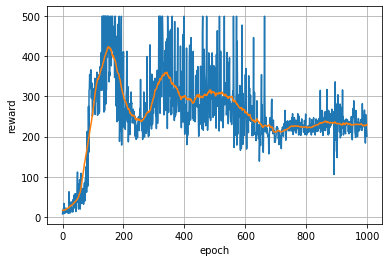

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 18        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


In [12]:
#primary_network.save('data/dQ_pendulum_simple.h5')

plt.plot(reward_list)
plt.plot(moving_average(reward_list, 55))
plt.grid()
plt.ylabel('reward')
plt.xlabel('epoch')
plt.savefig('data/doubleQ_simple_tanh.jpg', dpi=150)
plt.show()

primary_network.summary()

In [13]:
# playground
observation = env.reset()
observation = np.reshape(observation, (1,4))
done = False
i = 0
eps = 0.0

#while i < 20:
while not done:
    #pred = primary_network.predict(observation)
    #print(pred)
    #action = np.argmax(pred)
    #print(action)
    #action = int(input())
    
    action = choose_action(observation, primary_network, eps)
    
    observation_new, reward, done, info = env.step(action)
    observation = np.array([observation_new])
    env.render()
    i = i + 1
    
env.close()
print(i)

211


In [35]:
N_eps = 50
N_stat = 15

eps = np.linspace(0, 0.6, N_eps)
re_eps = np.zeros(N_eps)

for i in range(N_eps):
    for j in range(N_stat):
        observation = env.reset()
        done = False
        cnt = 0
        while not done:
            action = choose_action(observation, primary_network, eps[i])
        
            observation_new, reward, done, info = env.step(action)
            
            if done:
                observation_new = None
            # store in memory
            memory.add_sample((observation, action, reward, observation_new))

            #env.render()
            cnt += 1
            observation = observation_new
            
        loss = train(primary_network, memory, target_network if double_q else None)
        
        re_eps[i] += cnt
        
    print(f"Episode: {i}, Reward: {re_eps[i]/N_stat}, eps: {eps[i]:.2f}", end='\r')
    
re_eps /= N_stat

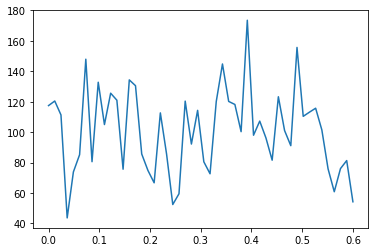

In [37]:
plt.plot(eps, re_eps)